<a href="https://colab.research.google.com/github/Tar-ive/STOCKS/blob/main/modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I am trying to put together the models as based on this paper titled "Sluggish news reactions: A combinatorial approach for synchronizing stock jumps"
https://s3.amazonaws.com/real.stlouisfed.org/wp/2024/2024-006.pdf

# Jump-Diffusion Model


In [1]:
import yfinance as yf
import pandas as pd

# Fetch historical data for a stock
def fetch_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

# Example: Fetch data for Apple Inc. from January 1, 2020, to December 31, 2020
ticker_symbol = 'NVDA'
start_date = '2000-01-01'
end_date = '2023-12-31'
data = fetch_stock_data(ticker_symbol, start_date, end_date)
print(data.head())

[*********************100%%**********************]  1 of 1 completed

                Open      High       Low     Close  Adj Close    Volume
Date                                                                   
2000-01-03  0.984375  0.992188  0.919271  0.975260   0.894608  30091200
2000-01-04  0.958333  0.960938  0.901042  0.949219   0.870721  30048000
2000-01-05  0.921875  0.937500  0.904948  0.917969   0.842055  18835200
2000-01-06  0.917969  0.917969  0.822917  0.858073   0.787112  12048000
2000-01-07  0.854167  0.881510  0.841146  0.872396   0.800251   7118400


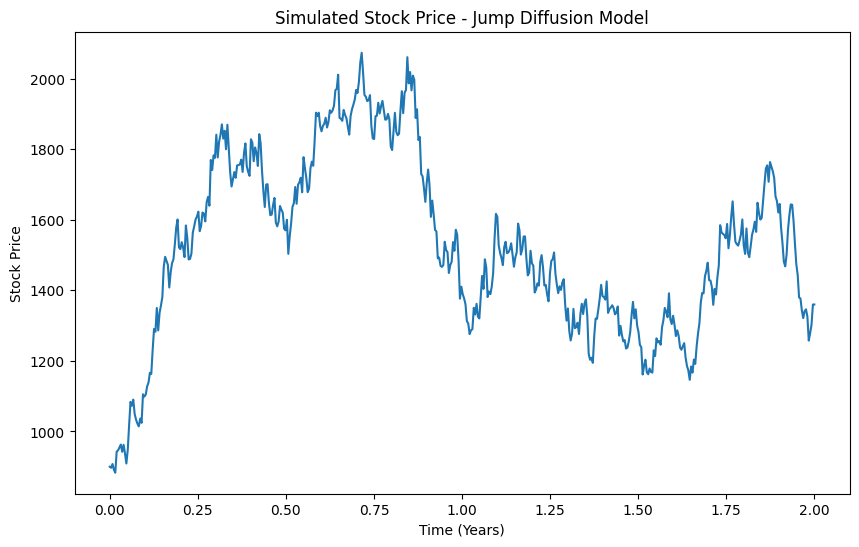

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Set the parameters for the jump-diffusion model
T = 2.0  # Time horizon, in years
mu = 0.5  # Expected return
sigma = 0.45  # Volatility
lambda_j = 0.3 # Jump intensity
mu_j = -0.2  # Expected jump size
sigma_j = 0.1  # Jump volatility
dt = 1/255  # Time step, in trading days
steps = int(T / dt)  # Number of steps

def simulate_jump_diffusion(S0, T, mu, sigma, lambda_j, mu_j, sigma_j, dt, steps):
    # Time array
    t = np.linspace(0, T, steps)
    # Initialize price array
    S = np.zeros(steps)
    S[0] = S0
    # Generate random components for diffusion and jump
    Z = np.random.standard_normal(steps - 1)
    J = np.random.poisson(lambda_j * dt, steps - 1)
    Y = np.random.normal(mu_j, sigma_j, steps - 1)
    # Simulate the process
    for i in range(1, steps):
        S[i] = S[i - 1] * (1 + mu * dt + sigma * np.sqrt(dt) * Z[i - 1] + Y[i - 1] * J[i - 1])
    return t, S

# Simulate stock price with S0=100
S0 = 900
t, S = simulate_jump_diffusion(S0, T, mu, sigma, lambda_j, mu_j, sigma_j, dt, steps)

t

S
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(t, S)
plt.title('Simulated Stock Price - Jump Diffusion Model')
plt.xlabel('Time (Years)')
plt.ylabel('Stock Price')
plt.show()

# RMILP

In [29]:
import cvxpy as cp
import numpy as np

In [30]:
n, m = 10, 20

In [32]:
!pip install mip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 441.8/441.8 kB 27.3 MB/s eta 0:00:00
  Attempting uninstall: cffi
    Found existing installation: cffi 1.16.0
    Uninstalling cffi-1.16.0:
      Successfully uninstalled cffi-1.16.0


In [1]:
from mip import Model, xsum, maximize, BINARY

In [2]:
stocks = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
stock_prices = {
    'AAPL': [180, 172, 195, 207, 210],
    'GOOG': [150, 152, 153, 140, 155],
    'MSFT': [420, 485, 412, 445, 460],
    'AMZN': [200, 201, 182, 190, 204]
}

In [3]:
max_jump = 2

In [4]:
model = Model()

In [5]:
jumps = {}
for stock in stocks:
    jumps[stock] = [model.add_var(var_type=BINARY) for _ in range(len(stock_prices[stock]))]

spread = model.add_var()

In [13]:
model.objective = maximize(spread)

# Define the constraints
for stock in stocks:
    prices = stock_prices[stock]
    for i in range(len(prices)):
        model += xsum(jumps[stock][j] * prices[max(0, k - max_jump):min(k + max_jump + 1, len(prices))]
                      for k in range(i, len(prices))
                      for j in range(max(0, k - max_jump), min(k + max_jump + 1, len(prices))))>= prices[i]

TypeError: Can not multiply with type <class 'list'>